# **WWA synthesis**

Climate Explorer code: https://gitlab.com/KNMI-OSS/climexp/climexp_numerical/-/blob/master/src/synthesis.f90?ref_type%24=%24heads

- test that CX code (which works on 95% confidence intervals) translates correctly into the equations in the paper

In [1]:
prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

In [2]:
df_in = read.csv("synthesis_in.txt", comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[1:3,]
models_in = df_in[4:nrow(df_in),]

In [3]:
# load 
df_out <- read.fwf("synthesis_out.txt", comment.char = "#", header = F, widths = c(5,5,12,12,12,12,13,2,99))
df_out <- df_out[!is.na(df_out$V8),]
colnames(df_out) <- c("y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model")

obs_out <- df_out[df_out$group == 1,]
obs_synth <- df_out[df_out$group == 2,]
models_out <- df_out[df_out$group == 3,]
models_synth <- df_out[df_out$group == 4,]
overall_synth <- df_out[df_out$group == 5,]
rep_unc <- 0.681
chi2_dof <- 11.85
mdl_unc <- 2.09

Warning message in readLines(file, n = thisblock):
“incomplete final line found on 'synthesis_out.txt'”


## **Mean & uncertainties of observations**

Original Fortran code:
```
!   compute mean & uncertainties of observations
!
    if ( nobs > 0 ) then
!       natural variability: assume 100% correlated
        do j=1,3
            s1 = 0
            do i=1,nobs
                s1 = s1 + data(j,i)
            end do
            obs(j) = s1/nobs
        end do

!       representation error from scatter of mean
        if ( nobs > 1 .and. lweighted ) then
            s2 = 0
            do i=1,nobs
                s2 = s2 + (data(1,i)-obs(1))**2
            end do
            sig_obs = 2*sqrt(s2/(nobs-1)) ! added factor 2; sig_obs now 2*std to represent 2sigma
            obs(2) = obs(1) - sqrt( (obs(1)-obs(2))**2 + sig_obs**2 ) 
            obs(3) = obs(1) + sqrt( (obs(3)-obs(1))**2 + sig_obs**2 )
        else
            sig_obs = 0 ! cannot estimate it from one point...
        end if
        do i=1,nobs
            data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_obs**2 )
            data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_obs**2 )
        end do
        obs(4) = obs(2)
        obs(5) = obs(3)
        if ( lwrite ) print *,'found combined observational estimate ',obs
        if ( sig_obs > 0 ) then
            if ( llog ) then
                print '(a,g12.3)','# representation uncertainty (2&sigma;) factor ',exp(sig_obs)
            else if ( lperc ) then
                print '(a,g12.3,a)','# representation uncertainty (2&sigma;) ',100*(-1+exp(sig_obs)),'%'
            else
                print '(a,g12.3)','# representation uncertainty (2&sigma;) ',sig_obs
            end if
        end if
    end if
```

Suppose that the measure derived from the $i$th observation (out of a total of $n$ observational datasets) is normally distributed with mean $\mu_i$ and variance $\sigma_i^2$. Then we have
\begin{align}
\bar{\mu} &= \frac{1}{n}\sum_i \mu_i  && \text{Overall best estimate}
\\
\sigma^2_{nat} &= \frac{1}{n}\sum_i \sigma_i  && \text{Natural variability}
\\
\sigma^2_{obs} &= \frac{\sum_i \left(\mu_i - \bar{\mu}\right)^2}{n-1} && \text{Spread of best estimates - representation error (add $2\sigma_{obs}$ to upper & lower bounds)}
\\
\sigma^2_{tot} &= \sigma^2_{nat} + 2\sigma_{obs}^2 && \text{Synthesised spread of all observations, including representation error}
\end{align}
&nbsp;

In practice, we work with confidence bounds ($\omega$, say) rather than with standard deviations, so that the $i$th dataset has best estimate $\mu_i$ and confidence bound $\omega_i$. Then we have
\begin{align}
\omega_{nat} &= \frac{1}{n}\sum_i \omega_i  && \text{Natural variability} 
\\
\omega_{tot} &= \bar{\mu} \pm \sqrt{\left(\omega_{nat} - \bar{\mu}\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty, including representation error}
\\
\omega_i &= \mu_i \pm \sqrt{\left(\omega_{i} - \mu_i\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty for observational dataset $i$}
\end{align}
&nbsp;

- **Confirm that these two are indeed equivalent**

In [198]:
# get mean of intervals to estimate natural variability component
obs = apply(obs_in[,c("est", "lower", "upper")], 2, mean)

# compute representation error from scatter of mean
nobs = nrow(obs_in)
s2 = sum((obs_in$est - obs[1])^2)
sig_obs = 2*sqrt(s2/(nobs-1))            # add 2 SDs to either side - representation uncertainty

# apply representation error to synthesis
obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )

# add representation error to observations
obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)

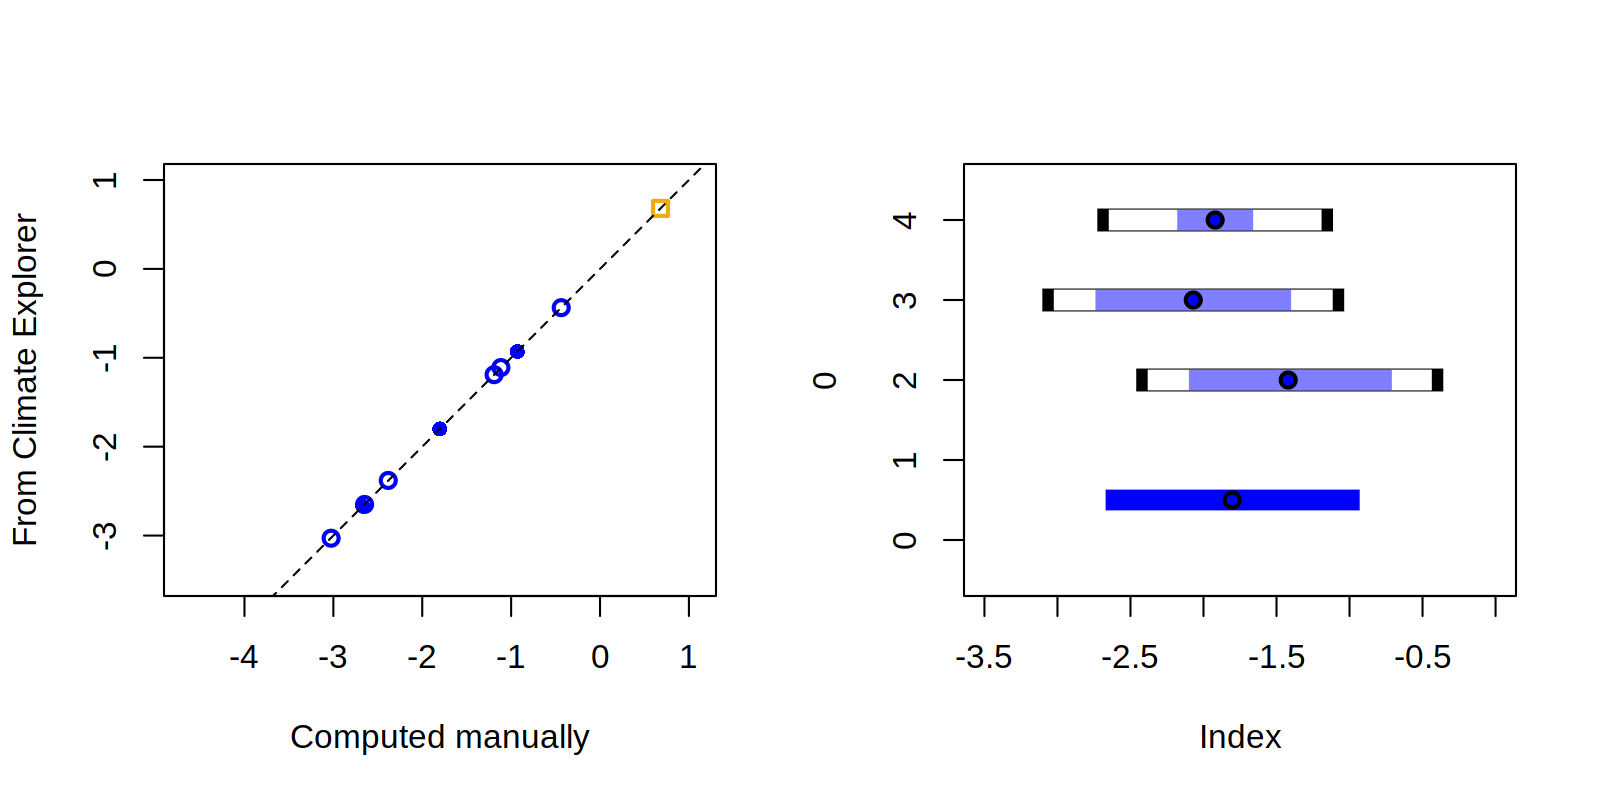

In [208]:
# check that my code does produce the same results as the Climate Explorer
prep_window(c(1,2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot estimated quantities
plot(obs, unlist(obs_synth[,c("est", "lower", "upper")]), col = "blue", pch = 16, ylim = c(-3.5, 1), asp = 1,
     xlab = "Computed manually", ylab = "From Climate Explorer")
points(c(obs_in$l_wb, obs_in$u_wb), c(obs_out$l_wb, obs_out$u_wb), col = "blue", pch = 1, lwd = 2)
points(sig_obs, rep_unc, pch = 0, col = "darkgoldenrod2", lwd = 2)
abline(0,1, lty = 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# synthesis plot
plot(0, type = "n", xlim = range(pretty(c(unlist(obs_in[,10:11])))), ylim = c(-0.5,4.5))

segments(y0 = 2:4, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 11, col = "black", lend = 2)
segments(y0 = 2:4, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 10, col = "white", lend = 1)
segments(y0 = 2:4, x0 = obs_in$lower, x1 = obs_in$upper, lwd = 10, col = adjustcolor("blue", 0.5), lend = 1)
points(obs_in$est, 2:4, pch = 21, bg = "blue", lwd = 2)

lines(obs[2:3], rep(0.5,2), col = "blue", lwd = 10, lend = 1)
points(obs["est"], 0.5, pch = 21, bg = "blue", lwd = 2)

## **Mean & uncertainties of models**

Original Fortran code:
```

!   compute mean & uncertainties of models
!
    call getsynmean(lweighted,data,n,nobs,sig_mod)
    if ( lwrite ) print *,'first guess of model mean is ',data(:,n+1)
    call getsynchi2(data,n,nobs,sig_mod,chi2)
    if ( lweighted ) then
        print '(a,g14.4)','# model chi2/dof = ',chi2/(n-nobs-1)
    end if
    if ( lweighted .and. .not.lnoave .and. chi2/(n-nobs-1) > 1 .and. sig_mod < 0 ) then
        ! compute sig_mod to make chi2/dof = 1
        syn_n = n ! copy to common as I am a F77 programmer and do not feel comfortable with f90 global variables
        syn_nobs = nobs
        syn_data(:,1:n) = data(:,1:n)
        s1 = 0
        s2 = data(3,n+1) - data(2,n+1)
        if ( syn_func(s1) <= 0 ) then
            write(0,*) 'synthesis: internal error: syn_func(0) should be > 0, not ',syn_func(s1)
            call exit(-1)
        end if
        s = syn_func(s2)
        do while ( s2 < 1e10 )
            s2 = 2*s2
            if ( s2 > 1e10 ) then
                write(0,*) 'synthesis: error: cannot find zero: ',s2
                call exit(-1)
            end if
            s = syn_func(s2)
            if ( s < 0 ) exit
        end do
        if ( lwrite ) print *,'bracketed sig_mod by ',s1,s2,', calling Brent'
        sig_mod = zbrent(syn_func,s1,s2,1e-4)
        !!!write(names(n)(len_trim(names(n))+1:),'(a,f4.2)') ' added ',sig_mod
        ! copy results back
        mod(1:3) = syn_data(1:3,n+1)
    else
        sig_mod = 0
        mod(1:3) = data(1:3,n+1)
    end if
    mod(4) = mod(2)
    mod(5) = mod(3)
    do i=nobs+1,n
        data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_mod**2 )
        data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_mod**2 )
    end do
    if ( lwrite ) print *,'found combined model estimate ',mod
```

Subroutines:
```
subroutine getsynmean(lweighted,data,n,nobs,sig_mod)
!
!   compute the mean of model data, either weighted with model error or unweighted
!   n is the number of input points, ..(n) denotes the average.
!
    implicit none
    logical,intent(in) :: lweighted
    integer,intent(in) :: n,nobs
    real,intent(in) :: sig_mod
    real,intent(inout) :: data(5,n+1)
    integer :: i,j
    real s1,ss2(3),w,w1
!
    s1 = 0
    ss2 = 0
    w1 = 0
    do i=nobs+1,n
        if ( lweighted ) then
            if ( abs(data(3,i) - data(2,i)) < 1e-6 ) then
                write(0,*) 'synthesis: error: upper and lower bound are equal: ',i,data(2,i),data(3,i)
                call exit(-1)
            end if
            if ( sig_mod > 0 ) then
                w = 1/((data(3,i) - data(2,i))**2 + (2*sig_mod)**2) ! factor 2 for sig_mod transforms from 2sigma to 4sigma
            else
                w = 1/(data(3,i) - data(2,i))**2
            end if
        else
            w = 1
        end if
        w1 = w1 + w
        s1 = s1 + w*data(1,i)
        do j=2,3
            ss2(j) = ss2(j) + (w*(data(1,i)-data(j,i)))**2
        end do
    end do
    s1 = s1/w1
    do j=2,3
        ss2(j) = sqrt(ss2(j))/w1
        if ( sig_mod > 0 ) then
            ss2(j) = sqrt(ss2(j)**2 + sig_mod**2)
        end if
    end do
    data(1,n+1) = s1
    data(2,n+1) = s1 - ss2(2)
    data(3,n+1) = s1 + ss2(3)
end subroutine getsynmean

subroutine getsynchi2(data,n,nobs,sig_mod,chi2)
!
!   compute chi2
!
    implicit none
    integer,intent(in) :: n,nobs
    real,intent(in) :: data(5,n+1)
    real,intent(out) :: sig_mod,chi2
    integer :: i
    real :: s1

    chi2 = 0
    s1 = data(1,n+1)
    do i=nobs+1,n
        if ( sig_mod > 0 ) then
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + (data(1,i)-s1)**2/((data(1,i)-data(2,i))**2 + sig_mod**2)
            else
                chi2 = chi2 + (s1-data(1,i))**2/((data(3,i)-data(1,i))**2 + sig_mod**2)
            end if
        else
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + ((data(1,i)-s1)/(data(1,i)-data(2,i)))**2
            else
                chi2 = chi2 + ((s1-data(1,i))/(data(3,i)-data(1,i)))**2
            end if
        end if
    end do
    chi2 = chi2*4 ! transformed to use 95%~2sigma CIs
end subroutine getsynchi2
```

In [27]:
getsynmean <- function(data, sig_mod = -1) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [29]:
getsynchi2 <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
        }
    }))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

In [43]:
# get initial estimate of model mean & calculate chi^2
mmean_1 <- getsynmean(models_in, sig_mod = -1)
chi2_1 <- getsynchi2(models_in, sig_mod = -1)
mdof <- nrow(models_in)-1
print(chi2_1 / mdof)

# estimate sig_mod such that chi^2/dof = 1
# function to be minimized in order to 
find_sigmod <- function(x) {
    
    chi2 <- getsynchi2(models_in, sig_mod = x)
    dof <- nrow(models_in)-1
    return(abs(chi2 - dof))
}

[1] 11.85206


In [44]:
sigmod <- optim(-1, find_sigmod, method = "Brent", lower = 0, upper = 5)$par

In [46]:
sigmod

[1] 2.088943

In [66]:
    if ( lweighted .and. .not.lnoave .and. chi2/(n-nobs-1) > 1 .and. sig_mod < 0 ) then
        ! compute sig_mod to make chi2/dof = 1
        syn_n = n ! copy to common as I am a F77 programmer and do not feel comfortable with f90 global variables
        syn_nobs = nobs
        syn_data(:,1:n) = data(:,1:n)
        s1 = 0
        s2 = data(3,n+1) - data(2,n+1)
        if ( syn_func(s1) <= 0 ) then
            write(0,*) 'synthesis: internal error: syn_func(0) should be > 0, not ',syn_func(s1)
            call exit(-1)
        end if
        s = syn_func(s2)
        do while ( s2 < 1e10 )
            s2 = 2*s2
            if ( s2 > 1e10 ) then
                write(0,*) 'synthesis: error: cannot find zero: ',s2
                call exit(-1)
            end if
            s = syn_func(s2)
            if ( s < 0 ) exit
        end do
        if ( lwrite ) print *,'bracketed sig_mod by ',s1,s2,', calling Brent'
        sig_mod = zbrent(syn_func,s1,s2,1e-4)
        !!!write(names(n)(len_trim(names(n))+1:),'(a,f4.2)') ' added ',sig_mod
        ! copy results back
        mod(1:3) = syn_data(1:3,n+1)
    else
        sig_mod = 0
        mod(1:3) = data(1:3,n+1)
    end if

[1] 165.9288

In [6]:
# get mean of intervals to estimate natural variability component
models = apply(models_in[,c("est", "lower", "upper")], 2, mean)

# compute representation error from scatter of mean
nmod = nrow(models_in)
s2 = sum((models_in$est - models_in[1])^2)
sig_mod = -1  # initial value - will be updated later

In [7]:
    sig_mod = x
    call getsynmean(.true.,syn_data,syn_n,syn_nobs,sig_mod)
    call getsynchi2(syn_data,syn_n,syn_nobs,sig_mod,chi2)
    syn_func = chi2 - (syn_n-syn_nobs-1)


[1] 3934.71